In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv("Walmart_Store_sales.csv")

In [3]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         150 non-null    float64
 1   Date          132 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  138 non-null    float64
 4   Temperature   132 non-null    float64
 5   Fuel_Price    136 non-null    float64
 6   CPI           138 non-null    float64
 7   Unemployment  135 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.5+ KB


In [5]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
mean,9.866667,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000
max,20.000000,2.771397e+06,1.000000,91.650000,4.193000,226.968844,14.313000


In [6]:
df.isnull().sum()

Store            0
Date            18
Weekly_Sales    14
Holiday_Flag    12
Temperature     18
Fuel_Price      14
CPI             12
Unemployment    15
dtype: int64

### Corrélation importante
🔴 Corrélations négatives fortes (bleu foncé)
Store ↔ CPI : -0.59

Quand l'inflation (CPI = Consumer Price Index) augmente, les ventes du magasin diminuent
Logique : Prix plus élevés → consommateurs achètent moins

CPI ↔ Unemployment : -0.35

Quand l'inflation augmente, le chômage diminue
Logique : Économie en surchauffe → plus d'emplois mais plus d'inflation

🔵 Corrélations négatives modérées
Temperature ↔ Store : -0.26

Plus il fait chaud, moins les ventes sont importantes
Hypothèse : Peut-être un magasin de vêtements d'hiver ou les gens sortent moins quand il fait très chaud

Weekly_Sales ↔ CPI : -0.29

Même logique que Store ↔ CPI

🟡 Corrélations positives faibles à modérées
Store ↔ Unemployment : 0.22

Corrélation faible et contre-intuitive
Peut indiquer que ce magasin vend des produits de première nécessité

Store ↔ Fuel_Price : 0.18

Légère corrélation positive
Hypothèse : Magasin situé près d'une station-service ou prix du carburant reflète l'activité économique

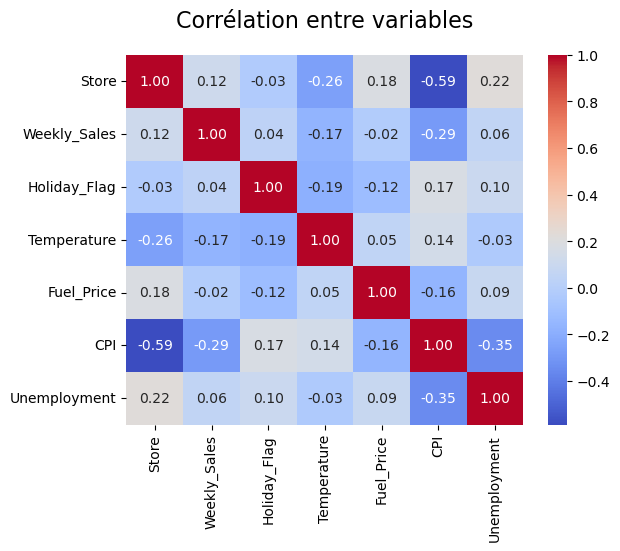

In [7]:
plt.title("Corrélation entre variables", fontsize=16, pad=20)

sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")

plt.show()

### Preprocessing

In [8]:
df = df.dropna(subset=["Weekly_Sales"])

In [9]:
df["Date"] = pd.to_datetime(df["Date"]) #permet de convertir la colonne en format datetime de pandas
df["Year"] = df["Date"].dt.year #créer le year avec uniquement l'année --> ex: 2025
df["Month"] = df["Date"].dt.month #créer la colonne month avec les mois en format 1-12
df["Day"] = df["Date"].dt.day #créer une colonne day avec le jour du mois
df["DayOfWeek"] = df["Date"].dt.dayofweek #crée une colonne "DayOfWeek" avec un code (0=Lundi, 1=Mardi, ..., 6=Dimanche)
df.drop(columns="Date", inplace=True) #pour finir, suppression de la colonne date 

C:\Users\adela\AppData\Local\Temp\ipykernel_24176\726473282.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["Date"] = pd.to_datetime(df["Date"]) #permet de convertir la colonne en format datetime de pandas


In [10]:
#Suppression des outliers
for col in ["Temperature", "Fuel_Price", "CPI", "Unemployment"]:
    mean, std = df[col].mean(), df[col].std()
    df = df[(df[col] >= mean - 3 * std) & (df[col] <= mean + 3 * std)]

### Features et Target

In [33]:
df_clean = df.dropna()

In [34]:
X = df_clean.drop(columns=["Weekly_Sales"])
y = df_clean["Weekly_Sales"]

### Preprocessing pipeline

In [35]:
categorical = ["Store", "Holiday_Flag"]
numerical = ["Temperature", "Fuel_Price", "CPI", "Unemployment", "Year", "Month", "Day", "DayOfWeek"]

In [41]:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical),
    ("cat", OneHotEncoder(drop="first", handle_unknown= "ignore"), categorical)
])

### Linear Regression

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
pipe_lr = Pipeline([
    ("preprocessing", preprocessor),
    ("model", LinearRegression())
])

In [44]:
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R2:", r2_score(y_test, y_pred))

RMSE: 149684.57457368862
R2: 0.9312793223354742


c:\Users\adela\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\adela\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [46]:
# Statistiques descriptives de y_test pour mieux comprendre le RMSE
print(f"Moyenne des ventes: {y_test.mean():.0f}")
print(f"Médiane des ventes: {y_test.median():.0f}")
print(f"Écart-type des ventes: {y_test.std():.0f}")
print(f"RMSE: {149684:.0f}")
print(f"RMSE/Moyenne: {149684/y_test.mean():.1%}")

Moyenne des ventes: 1186065
Médiane des ventes: 1029618
Écart-type des ventes: 591037
RMSE: 149684
RMSE/Moyenne: 12.6%


In [47]:
features = pipe_lr.named_steps["preprocessing"].get_feature_names_out()
coef = pipe_lr.named_steps["model"].coef_
coef_df = pd.DataFrame({"Feature": features, "Coefficient": coef})
print(coef_df.sort_values(by="Coefficient", ascending=False))

                  Feature   Coefficient
10         cat__Store_4.0  2.112972e+06
17        cat__Store_13.0  1.975536e+06
16        cat__Store_10.0  1.909599e+06
23        cat__Store_19.0  1.310019e+06
18        cat__Store_14.0  1.259366e+06
22        cat__Store_18.0  9.904759e+05
2                num__CPI  7.148366e+05
21        cat__Store_17.0  6.182832e+05
19        cat__Store_15.0  6.015770e+05
24        cat__Store_20.0  5.140257e+05
8          cat__Store_2.0  2.093604e+05
12         cat__Store_6.0  1.245011e+05
5              num__Month  3.062270e+04
7          num__DayOfWeek  2.200250e-08
4               num__Year -5.384522e+03
6                num__Day -3.644541e+04
3       num__Unemployment -5.547023e+04
0        num__Temperature -6.197420e+04
1         num__Fuel_Price -9.915188e+04
25  cat__Holiday_Flag_1.0 -1.416612e+05
13         cat__Store_7.0 -6.511288e+05
20        cat__Store_16.0 -7.481323e+05
14         cat__Store_8.0 -8.982085e+05
9          cat__Store_3.0 -1.310759e+06


### Ridge regression + Gridsearch

In [48]:
pipe_ridge = Pipeline([
    ("preprocessing", preprocessor),
    ("model", Ridge())
])

In [51]:
params = {"model__alpha": [0.01, 0.1, 1, 10, 100]}
gs_ridge = GridSearchCV(pipe_ridge, params, cv=5, scoring="neg_root_mean_squared_error")
gs_ridge.fit(X_train, y_train)

print("Best alpha:", gs_ridge.best_params_)
print("Best RMSE:", -gs_ridge.best_score_)

Best alpha: {'model__alpha': 0.01}
Best RMSE: 318360.6856694784


c:\Users\adela\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\adela\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\adela\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\adela\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\adela\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Foun

### LASSO REGRESSION + GRIDSEARCH

In [52]:
pipe_lasso = Pipeline([
    ("preprocessing", preprocessor),
    ("model", Lasso(max_iter=10000))
])

In [53]:
gs_lasso = GridSearchCV(pipe_lasso, params, cv=5, scoring="neg_root_mean_squared_error")
gs_lasso.fit(X_train, y_train)

print("--- LASSO ---")
print("Best alpha:", gs_lasso.best_params_)
print("Best RMSE:", -gs_lasso.best_score_)

c:\Users\adela\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.415e+10, tolerance: 2.251e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\adela\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\adela\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.200e+11, tolerance: 2.264e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\adela\anaconda3\Lib\site-packages\sklearn\linear_model\_coordi

--- LASSO ---
Best alpha: {'model__alpha': 100}
Best RMSE: 332602.32595968584


c:\Users\adela\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
